<a href="https://colab.research.google.com/github/Gaurav2912/Cronavirus-Tweet-Sentiment-Analysis/blob/main/Coronavirus_Tweet_Sentiment_Analysis_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Sentiment Analysis : Predicting sentiment of COVID-19 tweets</u></b>

## <b> Problem Description </b>

### This challenge asks you to build a classification model to predict the sentiment of COVID-19 tweets.The tweets have been pulled from Twitter and manual tagging has been done then.

### The names and usernames have been given codes to avoid any privacy concerns.

### You are given the following information:
1. Location
2. Tweet At
3. Original Tweet
4. Label

![social-media-marketing-1.jpg](https://dichvuquangcao.vn/wp-content/uploads/2021/04/social-media-marketing-1.jpg)

# **Coronavirus disease**

Coronavirus disease (COVID-19) is an infectious disease caused by the SARS-CoV-2 virus.
Most people who fall sick with COVID-19 will experience mild to moderate symptoms and recover without special treatment. However, some will become seriously ill and require medical attention.

It is a respiratory infection caused by a type of coronavirus that started in the year 2019. 

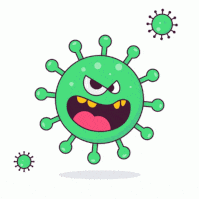

In [ ]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Imports and install some libraries**

In [ ]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Reading, Exploring and Visulization of the Data
import random
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.subplots import make_subplots

import time
import string
import nltk
import re
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

# Importing sklearn libraries for Machine Learning

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB , GaussianNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import precision_recall_curve,plot_precision_recall_curve,plot_roc_curve, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV

from lime.lime_text import LimeTextExplainer

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# For displaying ploty plot in colab notebook
import plotly.io as pio
pio.renderers.default = "colab"

In [ ]:
# path of folder
path = '/content/drive/MyDrive/Colab Notebooks/capstone project/Coronavirus Tweet Sentiment Project/'

# read csv file, utf-8 code error usually comes when the range of numeric values exceeding 0 to 127
# The solution was change the encoding to latin-1
tweet_df = pd.read_csv(path + 'Coronavirus Tweets.csv' , encoding='latin-1')

In [ ]:
# showing head of dataframe
tweet_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
# Check the dimension of data drame
tweet_df.shape

(41157, 6)

In [ ]:
num_rows = tweet_df.shape[0]
num_cols = tweet_df.shape[1]

print(f"This dataset contains {num_rows} rows and {num_cols} columns.")

This dataset contains 41157 rows and 6 columns.


----
**Confirm quickly with .info() methods the datatypes and null values in our dataframe.**

In [ ]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


We have seen that a **TweetAt**  is a string datatype, to extract any information from it, it must first be converted to a **datetime** object.

# Data Cleaning, Preprocessing and Feature engineering.


In [ ]:
def add_month(df_name, col_name):
  '''
  Convert the data type of column TweetAt str from  datetime64, 
  and create Month column.
  '''

  df_name[col_name] =  pd.to_datetime(df_name[col_name])
  df_name[col_name + '_month'] = df_name[col_name].dt.month

In [ ]:
def map_quarter(month_num):
  '''
  A quarter is a three-month period on a company's financial calendar, this function return quarter of that month.
  '''
  # January, February, and March 
  if month_num <  4: 
    return 'Q1'
  # April, May, and June
  elif month_num < 7:
    return 'Q2'
  # July, August, and September
  elif month_num < 10:
    return 'Q3'
  # October, November, and December 
  return 'Q4'

In [ ]:
# To create month columns
add_month(tweet_df, 'TweetAt')

# To create quarter column
tweet_df['Quarter'] =  tweet_df.apply(lambda x : map_quarter(x['TweetAt_month']), axis= 1)

# Create a column that have length of that tweet
tweet_df['Length of tweet'] = tweet_df['OriginalTweet'].apply(len)

In [ ]:
# Checking data type of new columns
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   UserName         41157 non-null  int64         
 1   ScreenName       41157 non-null  int64         
 2   Location         32567 non-null  object        
 3   TweetAt          41157 non-null  datetime64[ns]
 4   OriginalTweet    41157 non-null  object        
 5   Sentiment        41157 non-null  object        
 6   TweetAt_month    41157 non-null  int64         
 7   Quarter          41157 non-null  object        
 8   Length of tweet  41157 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 2.8+ MB


In [ ]:
# lets check the data frame, for new columns
tweet_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,TweetAt_month,Quarter,Length of tweet
0,3799,48751,London,2020-03-16,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,3,Q1,111
1,3800,48752,UK,2020-03-16,advice Talk to your neighbours family to excha...,Positive,3,Q1,237
2,3801,48753,Vagabonds,2020-03-16,Coronavirus Australia: Woolworths to give elde...,Positive,3,Q1,131
3,3802,48754,NaN,2020-03-16,My food stock is not the only one which is emp...,Positive,3,Q1,306
4,3803,48755,NaN,2020-03-16,"Me, ready to go at supermarket during the #COV...",Extremely Negative,3,Q1,310


**Get a quick statistical summary of the numeric columns with .describe()**

In [ ]:
tweet_df.describe().T

,count,mean,std,min,25%,50%,75%,max
UserName,41157.0,24377.000000,11881.146851,3799.0,14088.0,24377.0,34666.0,44955.0
ScreenName,41157.0,69329.000000,11881.146851,48751.0,59040.0,69329.0,79618.0,89907.0
TweetAt_month,41157.0,4.333673,2.488591,1.0,3.0,3.0,5.0,12.0
Length of tweet,41157.0,204.200160,68.655129,11.0,151.0,215.0,259.0,355.0


* Username and screen name are unique identifiers.
* Minimum length of tweet is 11.
* The length of a single tweet can not exceed 280, but here maximum length is 355.

[ Tweet can contain up to 280 characters or Unicode glyphs](https://developer.twitter.com/en/docs/counting-characters#:~:text=In%20most%20cases%2C%20the%20text,as%20more%20than%20one%20character.)

## Looking for missing values

In [ ]:
# conferming null values with diffretnt method 
tweet_df.isna().sum()

UserName              0
ScreenName            0
Location           8590
TweetAt               0
OriginalTweet         0
Sentiment             0
TweetAt_month         0
Quarter               0
Length of tweet       0
dtype: int64

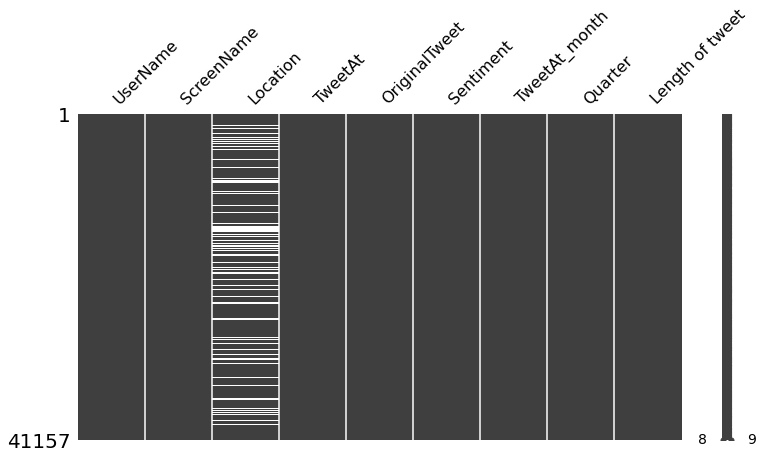

In [ ]:
# Lets visulize missing values positions using mnso
msno.matrix(tweet_df, figsize=(12,6));

white horizontal line are at position of null values

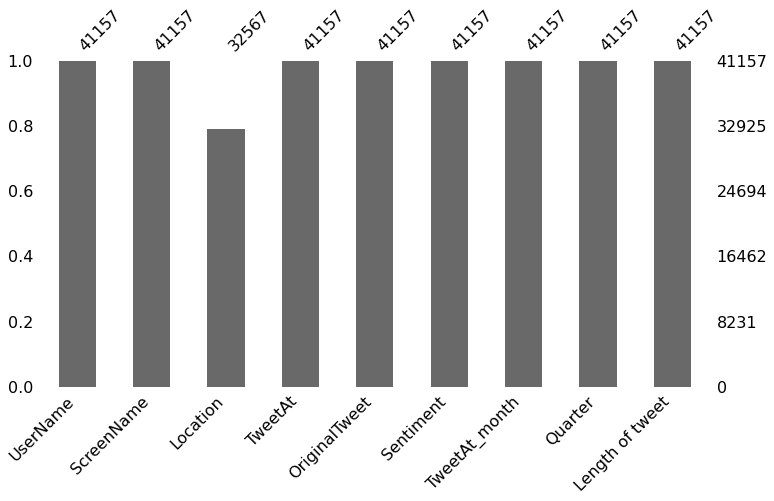

In [ ]:
msno.bar(tweet_df, figsize=(12,6));

* Location feature have almost 20 percent missing values.

<br/>
Since Tweet is a string data, it sometimes gets a null value as a blank space, let's check it out using isspace() method 

In [ ]:
tweet_df['OriginalTweet'].str.isspace().sum()

0

In [ ]:
# checking for duplicate rows in a Dataframe
sum(tweet_df.duplicated())

0

<p><img alt="Insight logo" src="https://drive.google.com/uc?export=view&id=15uX4fnuDMuki2xAnjK8wv-ifJhAkBtJ2" align="left" hspace="10px" vspace="0px"></p>

**Insights:**

* No duplicate values found.
* Only location Column have missing values.
* No missing values were found in the OriginalTweets and Sentiment columns.

In [ ]:
# Checking for unique values 
tweet_df.nunique().sort_values()

Quarter                4
Sentiment              5
TweetAt_month         12
TweetAt               30
Length of tweet      329
Location           12220
UserName           41157
ScreenName         41157
OriginalTweet      41157
dtype: int64

# Exploratory data analysis

In [ ]:
# set default gridtype, fontsize, figsize and palette
sns.set_style("whitegrid")
sns.set_palette(palette = ['#4169E1', '#FF5F15', '#4CBB17'])
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] =  (8,6)

In [ ]:
# Let us see the five unique sentiment of tweets
sentiment_count = tweet_df["Sentiment"].value_counts()
sentiment_count 

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

In [ ]:
# Arrange the sentiments in a particular order
sentiment_order = ['Extremely Positive', 'Positive', 'Neutral', 'Negative', 'Extremely Negative']
sentiment_count = sentiment_count.loc[sentiment_order] 
sentiment_count

Extremely Positive     6624
Positive              11422
Neutral                7713
Negative               9917
Extremely Negative     5481
Name: Sentiment, dtype: int64

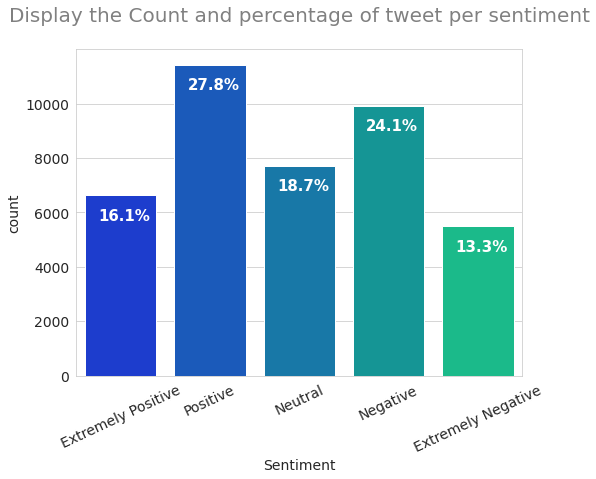

In [ ]:
#labels
labels = sentiment_count.index

#values
values = sentiment_count.values

total_tweets = values.sum()          #  oe just len(tweet_df)

for i, value in enumerate(values):
  
  # Calculating the percentage of tweets per sentiments
  percent = 100 * value / total_tweets
  
  # To write text on each bar of the bar plot
  plt.text(x= i- 0.25, y= value - 900,
            s= str(round(percent,1)) + '%', 
           fontsize=15, weight='bold', color= 'white')

# barplot
sns.barplot(x= labels, y = values, palette= 'winter')

# set title, x and y labels 
plt.title('Display the Count and percentage of tweets per sentiment\n', size=20, color='grey');
plt.xlabel('Sentiment')
plt.ylabel('count')

# Rotating x-label
plt.xticks(rotation=25);

* All twitter sentiment is in significant numbers.
* There's more to tweets with a positive sentiment than a negative.

**Let's see a random tweets from each sentiment**

In [ ]:
def sentiment_tweets(sentiment):
    
    '''return a series of that particular sentiment'''  

    # Using conditional selection 
    return tweet_df["OriginalTweet"][tweet_df['Sentiment'] == sentiment]

# Series of Extremely Positive Sentiment tweets
ext_pos_tweets = sentiment_tweets('Extremely Positive')

# Series of Positive Sentiment tweets
pos_tweets = sentiment_tweets('Positive')

# Series of Neutral Sentiment tweets
neut_tweets = sentiment_tweets('Neutral')

# Series of Negative Sentiment tweets
neg_tweets = sentiment_tweets('Negative')

# Series of Extremely Negative Sentiment tweets
ext_neg_tweets = sentiment_tweets('Extremely Negative')

In [ ]:
# random integer between 0 to 100
random_num = random.randint(0, 100)

print("Extremely Positive sentiment tweet:\n")
print(ext_pos_tweets.iloc[random_num])
print(120 * '_', end= '\n' * 3)


print("Positive sentiment tweet:\n")
print(pos_tweets.iloc[random_num])
print(120 * '_', end= '\n' * 3)

print("Neutral sentiment tweet:\n")
print(neut_tweets.iloc[random_num])
print(120 * '_', end= '\n' * 3)

print("Negative sentiment tweet:\n")
print(neg_tweets.iloc[random_num])
print(120 * '_', end= '\n' * 3)

print("Extremely Negative sentiment tweet:\n")
print(ext_neg_tweets.iloc[random_num])

Extremely Positive sentiment tweet:

NOT ALL BUSINESSES CAN HAVE THEIR EMPLOYEES WORK FROM HOME Retail restaurants coffee shops entertainment venues optometrists grocery stores bodegas non profits that work in the field veterinarian offices dentists mailing centers like UPS Store
________________________________________________________________________________________________________________________


Positive sentiment tweet:









#coronavirusuk
________________________________________________________________________________________________________________________


Neutral sentiment tweet:

The produce section at my local supermarket on College St this morning. #COVID-19. #toronto https://t.co/HRJy2vwX0A
________________________________________________________________________________________________________________________


Negative sentiment tweet:




https://t.co/gp65SNkBiw https://t.co/oPNIGTT6Zt
________________________________________________________________________________

**Histogram for Tweet Length**

In [ ]:
fig = px.histogram(tweet_df, x= 'Length of tweet', marginal="box", 
                   title="Histogram for Length of all tweets")

fig.show()

<p><img alt="Insight logo" src="https://drive.google.com/uc?export=view&id=15uX4fnuDMuki2xAnjK8wv-ifJhAkBtJ2" align="left" hspace="10px" vspace="0px"></p>

>**Insights:**

* The boxplot and histogram shows that the length of the tweets is negatively skewed.
* The tallest tower is near 255.
* The second is near 280 as the Twitter official web page shows, which is the maximum limit of characters in a single tweet.

<br/>

**Let us now see the statistical behavior length of all tweets by sentiment**


In [ ]:
# groupby Sentiment, then see statistical information by describe()
tweet_df.groupby('Sentiment')['Length of tweet'].describe()

,count,mean,std,min,25%,50%,75%,max
Sentiment,,,,,,,,
Extremely Negative,5481.0,221.479839,59.985132,14.0,181.0,237.0,271.0,355.0
Extremely Positive,6624.0,228.237470,58.390527,19.0,192.0,241.0,275.0,338.0
Negative,9917.0,203.334174,67.117114,18.0,151.0,212.0,257.0,331.0
Neutral,7713.0,168.160897,72.648841,11.0,109.0,160.0,229.0,325.0
Positive,11422.0,207.056558,66.651587,11.0,156.0,218.0,259.0,350.0


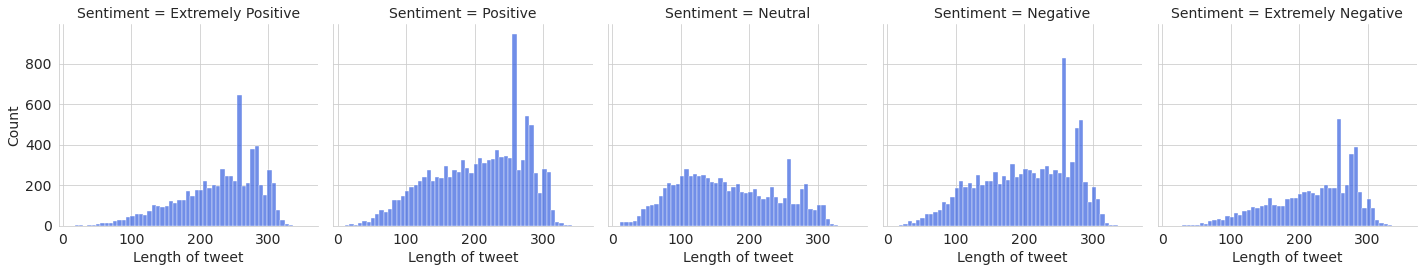

In [ ]:
# Histogram of length of all tweets per sentiment
sns.displot(data= tweet_df, x= 'Length of tweet', col= 'Sentiment', col_order= sentiment_order, height= 4);

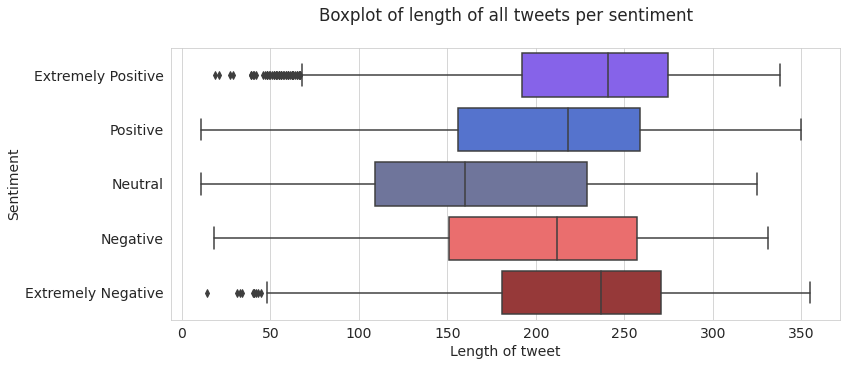

In [ ]:
plt.figure(figsize= (12,5))
palette= ['#7C4DFF','#4169E1', '#676FA3', '#FF5959', '#A52A2A']

# Boxplot of length of all tweets per sentiment
sns.boxplot(x= 'Length of tweet', y= 'Sentiment', data= tweet_df, order= sentiment_order, orient= 'h',palette= palette)
plt.title('Boxplot of length of all tweets per sentiment\n');

<p><img alt="Insight logo" src="https://drive.google.com/uc?export=view&id=15uX4fnuDMuki2xAnjK8wv-ifJhAkBtJ2" align="left" hspace="10px" vspace="0px"></p>

>**By looking Histogram and Box-plot**
 
 **The length of :**

  * Neutral sentiment tweet is positively skewed, rest are negatively skewed, this means that the percentage share of tweets with neutral sentiment is higher for tweets of shorter length.
  * Extremely positive and extremely negative sentiments tweets follow the same distribution.
  * Positive and Extremely negative sentiments tweets follow the same distribution.

<br/>

**Let's Explore the Location Feature**

In [ ]:
# Top 30 tweets Location
locations = tweet_df['Location'].value_counts() 
locations.iloc[:30]

London                     540
United States              528
London, England            520
New York, NY               395
Washington, DC             373
United Kingdom             337
Los Angeles, CA            281
India                      268
UK                         232
Australia                  225
USA                        223
Canada                     191
England, United Kingdom    191
Toronto, Ontario           160
Global                     159
Chicago, IL                155
California, USA            153
San Francisco, CA          152
Boston, MA                 150
New York, USA              140
New Delhi, India           138
Atlanta, GA                126
New York                   126
Mumbai, India              109
Worldwide                  101
Lagos, Nigeria              99
Houston, TX                 98
Austin, TX                  98
Texas, USA                  98
London, UK                  96
Name: Location, dtype: int64

<p><img alt="Insight logo" src="https://drive.google.com/uc?export=view&id=15uX4fnuDMuki2xAnjK8wv-ifJhAkBtJ2" align="left" hspace="10px" vspace="0px"></p>

>**Insights:**
  * Lots of locations are repeated, like 
    * London  
    * London, England
    * London, UK 

  * Location is a mix of cities, states and countries, not contain single feature.

  * As the location suggests, most of the places are from English speaking countries or country where people understand English, such as UK, USA, India, Canada, Australia etc., and among these most of them are also from the US and UK.

<br/>


<p><img alt="Insight logo" src="https://drive.google.com/uc?export=view&id=1MUmlmWazOcCyU7m30AwZuDKaoeZ2Gizi" align="left" hspace="25px" vspace="20px" width="50" height="60" ></p>


**Donut plot** 
<br/>
location that have more than 100  tweets

In [ ]:
#labels
lab = locations[locations>100].keys().tolist()
#values
val = locations[locations>100].values.tolist()

data = go.Pie(labels = lab ,
               values = val ,
               marker = dict(line = dict(color = "white",
                                         width =  1.3)
                            ),
               rotation = 90,
               hoverinfo = "label+value+text",
               hole = .5
              )

layout = go.Layout(dict(title = "Location that have more than 100 tweets",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                       )
                  )


fig = go.Figure(data = [data],layout = layout)
iplot(fig)

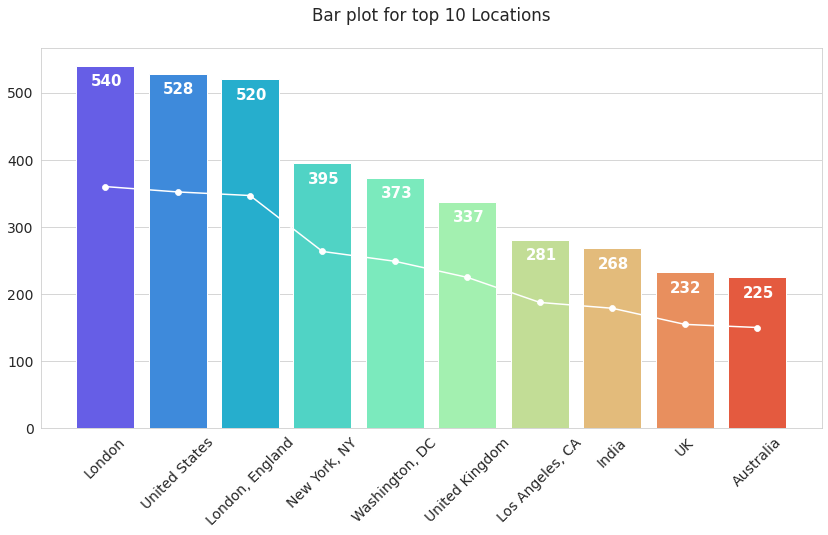

In [ ]:
# Bar plot for top 10 Locations
plt.figure(figsize= (14,7))
sns.barplot(x= locations.iloc[:10].index, y= locations.iloc[:10].values, palette= 'rainbow')

# white line
sns.lineplot(x= locations.iloc[:10].index, y= locations.iloc[:10].values / 1.5 , color= 'white', marker= 'o')


for i, value in enumerate(locations.iloc[:10].values):
  
  # To write text on each bar of the bar plot
  plt.text(x= i- 0.2, y= value - 30, s= value, 
            fontsize= 15, weight='bold', color= 'white')

plt.title('Bar plot for top 10 Locations\n');
plt.xticks(rotation= 45);

**Let's analyze tweets per month and quarter**

In [ ]:
tweet_df.columns

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment', 'TweetAt_month', 'Quarter', 'Length of tweet'],
      dtype='object')

In [ ]:
tweet_df.groupby('TweetAt_month')['UserName'].count()

TweetAt_month
1       630
2       954
3     26309
4      2479
5      1131
6      1742
7      1843
8      1881
9      1471
10     1005
11      909
12      803
Name: UserName, dtype: int64

There was a sudden jump in tweets in the month of March when there was an outbreak of Corona, after that the tweet has decreased gradually.

In [ ]:
# number of tweets in each quarter
tweet_per_quarter = tweet_df.groupby('Quarter')['UserName'].count()
tweet_per_quarter

Quarter
Q1    27893
Q2     5352
Q3     5195
Q4     2717
Name: UserName, dtype: int64

In [ ]:
# number of tweets Sentiment in each quarter
Sentiment_per_quarter= tweet_df.groupby(['Quarter','Sentiment'])['UserName'].count()
Sentiment_per_quarter 

Quarter  Sentiment         
Q1       Extremely Negative    3916
         Extremely Positive    4341
         Negative              6907
         Neutral               5066
         Positive              7663
Q2       Extremely Negative     655
         Extremely Positive     903
         Negative              1247
         Neutral               1056
         Positive              1491
Q3       Extremely Negative     600
         Extremely Positive     910
         Negative              1152
         Neutral               1024
         Positive              1509
Q4       Extremely Negative     310
         Extremely Positive     470
         Negative               611
         Neutral                567
         Positive               759
Name: UserName, dtype: int64

In [ ]:
# number of tweet per sentiment in 1st quarter divided by total number of tweet in 1st quarter , then multiplyed by 100 
# gives the percentage of tweet in 1st quarter per sentiment
100 * Sentiment_per_quarter['Q1']  / tweet_per_quarter['Q1']

Sentiment
Extremely Negative    14.039365
Extremely Positive    15.563044
Negative              24.762485
Neutral               18.162263
Positive              27.472843
Name: UserName, dtype: float64

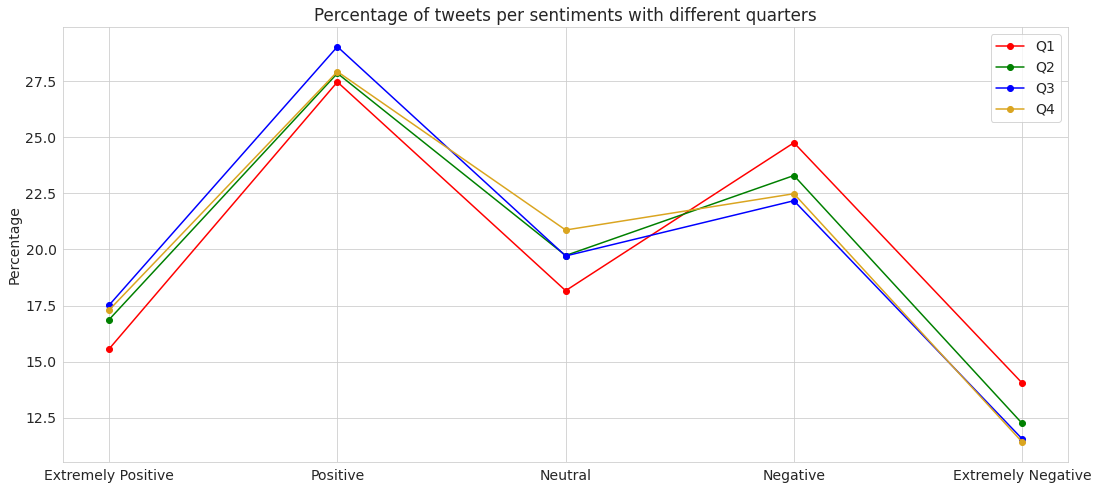

In [ ]:
# I will do what I have done above for all quarter and then I plot them

# blank figure
plt.figure(figsize= (18,8))

# color pallete
col = ['#FF0000', '#008000', '#0000FF', '#DAA520']

# list of quqters
Q_list = ['Q1', 'Q2', 'Q3', 'Q4']

for i, Q in enumerate(Q_list):
  
  senti_percent =  100 * Sentiment_per_quarter[Q] / tweet_per_quarter[Q]
  
  # sentiments_order is list that we have created above
  senti_percent = senti_percent.loc[sentiment_order]

  # line plot 
  plt.plot(sentiment_order, senti_percent.values, color= col[i], marker= 'o', label = Q)


plt.title('Percentage of tweets per sentiments with different quarters')
plt.ylabel('Percentage')
plt.legend(loc ="upper right");

**How to interpret this graph**

Let's start with the 1st quarter. We know that there were a total of 27,893 tweets in the first quartet, out of them
  * 15.56 %  of them were Extremely Positive.
  * 27.47 %  of them were Positive.
  * 18.16 % of them were Neutral.
  * 24.76 % of them were Negative. 
  * 14.03 % of them were Extremely Negative.

same with rest.
<br/>
<br/>
<p><img alt="Insight logo" src="https://drive.google.com/uc?export=view&id=15uX4fnuDMuki2xAnjK8wv-ifJhAkBtJ2" align="left" hspace="10px" vspace="0px"></p>

>**Insights:**

* First quarter has the highest percentage of negative and extreme negative tweets.
* Third quarter has the highest percentage of positive and extreme positive tweets.
*  Fourth quarter has the highest percentage of Neutral tweets.
*  Although the difference in percentage is not significantly large.

# **Correlation check**


In [ ]:
tweet_df.columns

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment', 'TweetAt_month', 'Quarter', 'Length of tweet'],
      dtype='object')

In [ ]:
# User name and ScreenName are unique datatype so there is no neeed of converting them into dummy variables
# I am selecting only Sentiment and Quarter
df_objs = tweet_df[['Sentiment', 'Quarter']]

# Creating dummy variables 
df_objs = pd.get_dummies(df_objs)

# concate with Length of tweet columns 
df_final = pd.concat([df_objs, tweet_df['Length of tweet']], axis= 1)

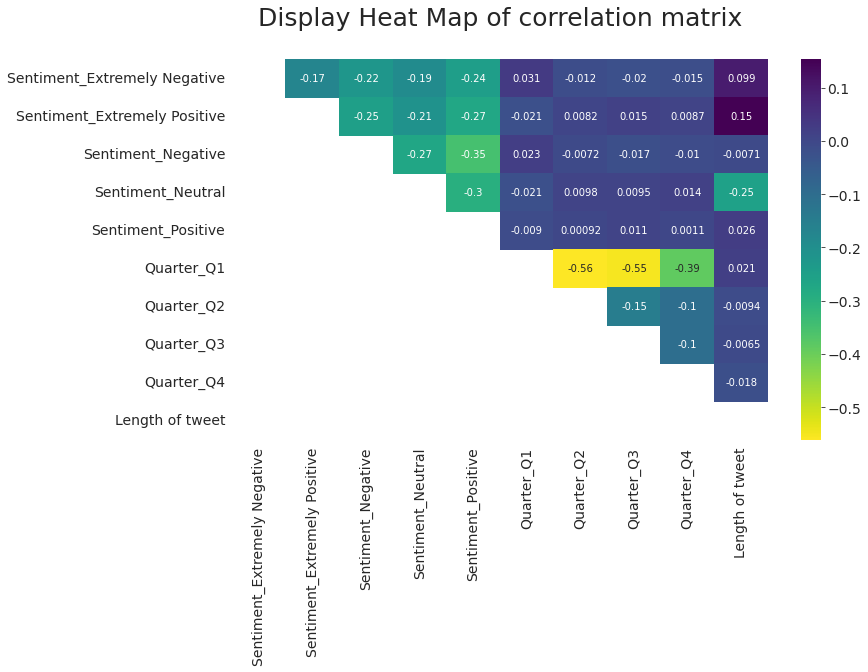

In [ ]:
plt.figure(figsize= (12,7))

# for finding correlation matrix , using .corr() method
corr_df = df_final.corr()

# creating mask for lower triangular matrix
mask = np.tril(np.ones_like(corr_df))

# plotting heat map of correlation matrix
sns.heatmap(corr_df, annot= True, cmap= 'viridis_r', annot_kws={"size":10}, mask= mask)

# add title
plt.title("Display Heat Map of correlation matrix\n", fontsize= 25);

* Tweet length is negatively correlated with neutral sentiment, as we saw in the box plot and slightly positively correlated with extreme sentiments.


# **Natural language processing part (NLP)**

**Punctuation**

Punctuation is the use of spacing, conventional signs, and certain typographical devices as aids to the understanding and correct reading of written text, whether read silently or aloud.

----
**Stop Words**

Stop words are a set of commonly used words in a language. Examples of stop words in English are “a”, “the”, “is”, “are” and etc. Stop words are commonly used in Text Mining and Natural Language Processing (NLP) to eliminate words that are so commonly used that they carry very little useful information.

---
**Stemming and Lemmatisation**

Stemming operation bundles together words of same root. e.g. stem operation bundles "response" and "respond" into a common "respon"

---
Remove urls

In [ ]:
# list of english's stop words and punctuation
eng_stop_words = stopwords.words('english')
punctuation_lst = string.punctuation

# create an object of stemming function
stemmer = SnowballStemmer("english")

def text_process(msg):
    '''
    It will remove punctuation and english's stop words from text, and stems each word in the given text.
    '''
    # Using list comprihansion.
    # list of all not punctuation english characters 
    nopunc_lst =[char for char in msg if char not in punctuation_lst]
    nopunc_str= ''.join(nopunc_lst) 

    words = nopunc_str.split() 
    # steam the word it is not english stopword
    text_lst= [ stemmer.stem(word) for word in words if word.lower() not in eng_stop_words]
    
    return ' '.join(text_lst)

In [ ]:
reg_exp = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

# remove urls and html
tweet_df['Text'] = tweet_df['OriginalTweet'].str.replace(reg_exp, '')

In [ ]:
# Lets see some example
print("Tweet with urls:\n")
print("First tweet:\n")
print(tweet_df['OriginalTweet'].iloc[2])
print('\n')

print("secound tweet:\n")
print(tweet_df.iloc[173]['OriginalTweet'])
print(120 * '_', end = '\n'*2)

print("Tweet after removal of urls:\n")
print("First tweet:\n")
print(tweet_df['Text'].iloc[2])
print('\n')

print("secound tweet:\n")
print(tweet_df.iloc[173]['Text'])

Tweet with urls:

First tweet:

Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P


secound tweet:

https://t.co/r9skYbYiHt CALLING SMALL BUSINESSES: Chicago's Department of Business Affairs &amp; Consumer Protection (BACP) is soliciting your feedback to develop resources and measures to support small businesses that have been impacted by COVID-19. Please fill out this survey ASAP.
________________________________________________________________________________________________________________________

Tweet after removal of urls:

First tweet:

Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak 


secound tweet:

 CALLING SMALL BUSINESSES: Chicago's Department of Business Affairs &amp; Consumer Protection (BACP) is soliciting your feedback to develop resources and measures to support small businesses that have been impacted by COVID-19. Please fill 

In [ ]:
# It will remove punctuation and english's stop words from text, and stems each word in the given text.
tweet_df['Text'] = tweet_df['Text'].apply(text_process)

In [ ]:
# Find length of Text
tweet_df['Length of Text'] = tweet_df['Text'].apply(len)

**Hashtag**

On Twitter, adding a “#” to the beginning of an unbroken word or phrase creates a hashtag. When you use a hashtag in a Tweet, it becomes linked to all of the other Tweets that include it. Including a hashtag gives your Tweet context and allows people to easily follow topics that they're interested in, it also help in finding trending topics in twitter.

<center><img alt="Insight logo" src="https://marketing.wtwhmedia.com/wp-content/uploads/2017/03/hashtag_iStock_000047220610_Illustration_650px.jpg" align="center" hspace="10px" vspace="10px" width="160" height="160" ></center>

<br/>

[On Twitter, if I write the same hashtag ten times in the same Tweet, will it be considered as ten or only one?](https://www.quora.com/On-Twitter-if-I-write-the-same-hashtag-ten-times-in-the-same-Tweet-will-it-be-considered-as-ten-or-only-one)

In [ ]:
def find_tags(row_string):
    '''
    It will extract hashtags from that tweet.  
    '''
    
    string_lst = row_string.split()

    # use a list comprehension to find list items that start with #
    tags = [word.replace('#', '') for word in  string_lst  if word.startswith('#')]
    
    # For uniqusess, only for hashtag
    tags_set = set(tags)  

    return ' '.join(tags_set)

In [ ]:
tweet_df['Hashtags'] = tweet_df['OriginalTweet'].apply(find_tags)

In [ ]:
# CountVectorizer object
cv = CountVectorizer()

# Define helper functions
def top_n_words(text_data, n_words, plot= False, palette= None, bow_model = cv):
    '''
    returns a tuple or plot of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample.
    '''
    
    # fit_transform a CountVectorizer
    matrix = bow_model.fit_transform(text_data)

    # tuple of word and their accompanying counts, 
    # Imagine bag of word , I am summing across axis= 0
    freqs = zip(bow_model.get_feature_names(), matrix.sum(axis=0).tolist()[0])    

    # sort from largest to smallest, on the basis of count and -x[1] for desending order
    tups_of_word = (sorted(freqs, key=lambda x: -x[1])[:n_words])  

    # typecast to dictionary
    dict_of_words =   dict(tups_of_word)

    top_words= list(dict_of_words.keys())
    top_values= list(dict_of_words.values())
    
    # if polt is True
    if plot:
      plt.figure(figsize= (10,6))
      sns.barplot(x= top_words, y = top_values, palette= palette)
      plt.ylabel('count')
      plt.xticks(rotation=90);

    # else return a tuple
    else: 
      return top_words, top_values

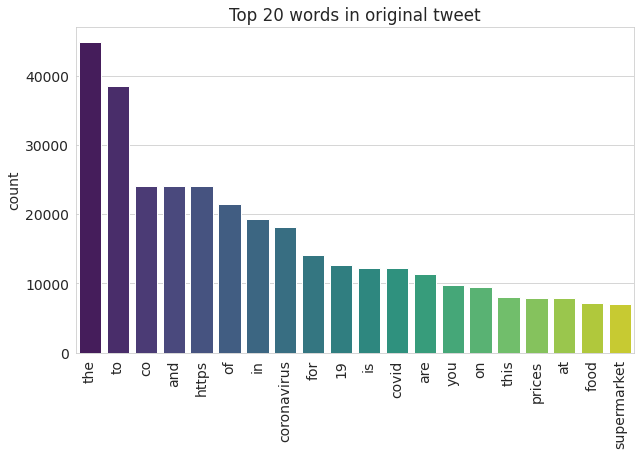

In [ ]:
# Top 20 words in original tweet
top_n_words(text_data=  tweet_df['OriginalTweet'], 
            n_words= 20,  plot=True,  palette= 'viridis')
plt.title('Top 20 words in original tweet');

We noticed that the data is full of stop words so it is necessary to remove them also.

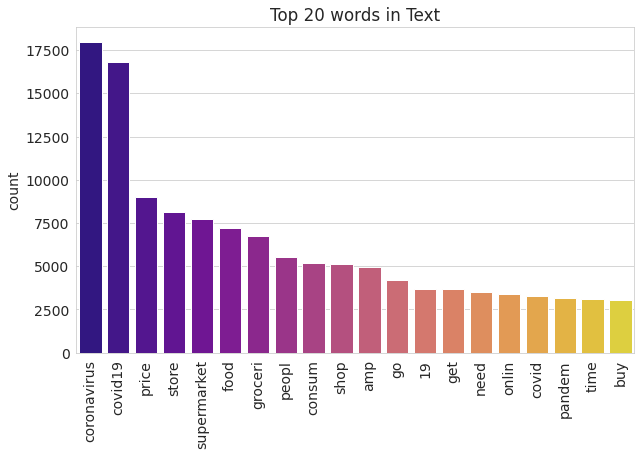

In [ ]:
# Top 20 words in tweets after removal of punctuation, stopwords and stemming
top_n_words(text_data=  tweet_df['Text'], 
            n_words= 20,  plot=True,  palette= 'plasma')
plt.title('Top 20 words in Text');

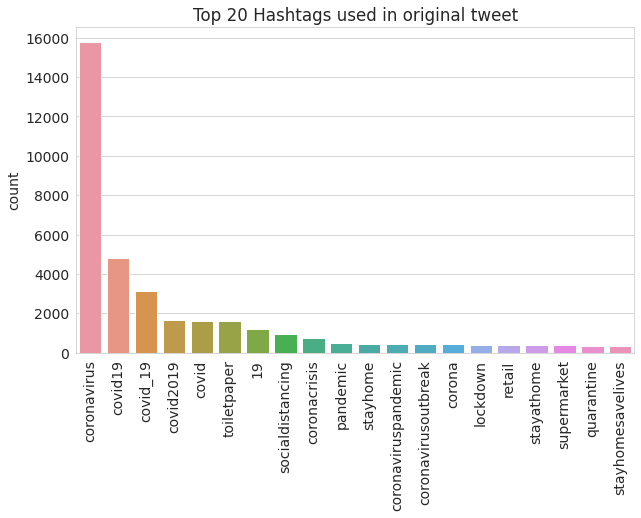

In [ ]:
# Hashtag 
top_n_words(text_data=  tweet_df['Hashtags'], 
            n_words= 20,  plot=True)
plt.title('Top 20 Hashtags used in original tweet');

<p><img alt="Insight logo" src="https://drive.google.com/uc?export=view&id=15uX4fnuDMuki2xAnjK8wv-ifJhAkBtJ2" align="left" hspace="10px" vspace="0px"></p>

>**Insights:**

* Most of the hashtags are about corona virus outbreak and pandemic, Social distancing, lockdown , staying at home etc..
* Due to the lockdown, people are also facing problems due to the closure of supermarkets, shortage of food, and running out of toilet papers. 

<br/>

**Lets compare the length of Text and original tweet**

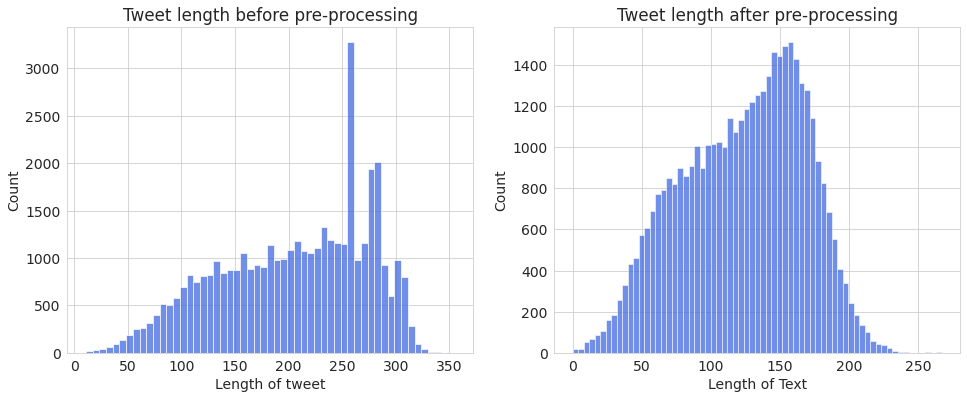

In [ ]:
fig, ax = plt.subplots(nrows= 1, ncols= 2, figsize= (16,6))

ax[0].set_title("Tweet length before pre-processing")
sns.histplot(data= tweet_df, x= 'Length of tweet', ax= ax[0])

ax[1].set_title("Tweet length after pre-processing")
sns.histplot(data= tweet_df, x= 'Length of Text', ax= ax[1]);

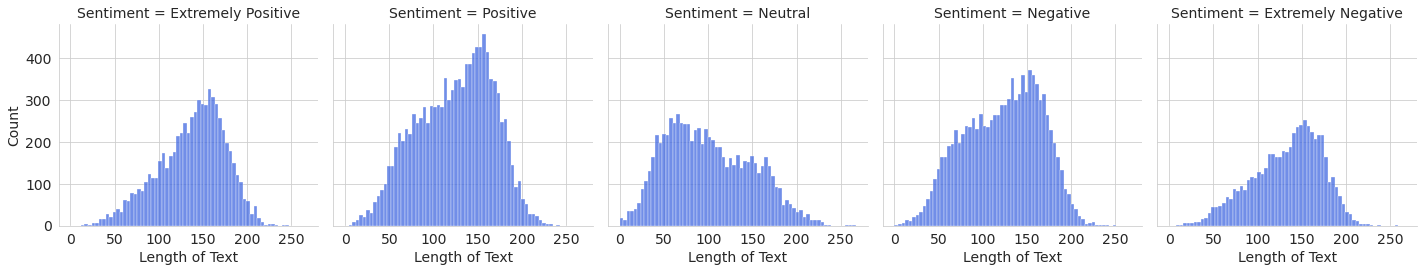

In [ ]:
sns.displot(data= tweet_df, x= 'Length of Text', col= 'Sentiment', col_order= sentiment_order, height= 4);

<p><img alt="Insight logo" src="https://drive.google.com/uc?export=view&id=15uX4fnuDMuki2xAnjK8wv-ifJhAkBtJ2" align="left" hspace="10px" vspace="0px"></p>

>**Insights:**
* The length and skewness are reduced after processing the original tweet.
* Disproportionate jumps are gone at specific length.

<br/>

>In Text length :

* Neutral sentiment tweet is positively skewed, extreme sentiments are negatively skewed, positively and negatively sentiments are little bit negatively skewed.
* All zero length tweet are labled as neutral sentiment.
* Extremely positive and extremely negative sentiments tweets follow the same distribution.
* Positive and Extremely negative sentiments tweets follow the same distribution.


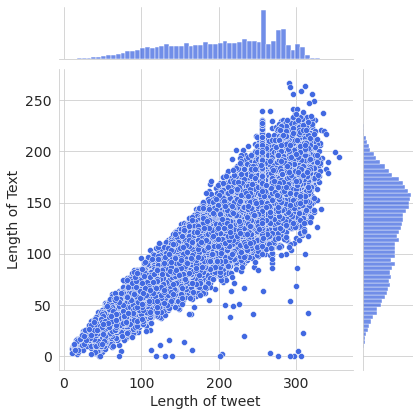

In [ ]:
sns.jointplot(data= tweet_df, x= 'Length of tweet', y= 'Length of Text', kind= 'scatter');

* Few points outside the general trend are heavily preprocessed (removal of stop word and punchuation, stemming).

**Let's remove tweet that have zero length after text preprocessing**

In [ ]:
# Tweet with only space 
tweet_df['Text'].str.isspace().sum()

0

In [ ]:
(tweet_df['Length of Text'] == 0).sum()

11

In [ ]:
# Lets check zero lengt tweets
tweet_df[tweet_df['Length of Text'] == 0]

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,TweetAt_month,Quarter,Length of tweet,Text,Length of Text,Hashtags
583,4382,49334,NaN,2020-03-16,#????_???_?????? ???? ???????..? ?? ?????? ?? ...,Neutral,3,Q1,297,,0,????_???_??????
5214,9013,53965,NaN,2020-03-18,???? ???????? ??????????? - ???????? ?????????...,Neutral,3,Q1,201,,0,???????????'? ???????
13843,17642,62594,"Pashtoonistan Watt, Kabul",2020-03-21,? ???? ????? ???? ??? ?????? ??? ???\r\r\n\r\r...,Neutral,3,Q1,276,,0,
14840,18639,63591,???? ??????,2020-03-22,???? ??????? ??????? ????? ??? ?????? ??????? ...,Neutral,3,Q1,119,,0,?????_???_?????
16920,20719,65671,?????,2020-03-23,???? ??????? ??????? ???? ????? ???? ???? ????...,Neutral,3,Q1,131,,0,
16924,20723,65675,??????? ??????? ????????,2020-03-23,????? ?\r\r\n\r\r\n???? ??? ???? ??? ?????????...,Neutral,3,Q1,140,,0,????????_?????? ???????_??????
18437,22236,67188,"Kanpur, UP India",2020-03-23,????? ?? ??????? ?? ??????? ???? ???? ????????...,Neutral,3,Q1,306,,0,
28987,32786,77738,"Massachusetts, USA",2020-05-04,And here we are. ???? https://t.co/IDgWlcpoIl,Neutral,5,Q2,46,,0,
29888,33687,78639,NaN,2020-06-04,???? ????? \r\r\n????? ??? ? ?? ?? ??\r\r\n\r\...,Neutral,6,Q2,72,,0,???????
32455,36254,81206,"Islamabad, Pakistan",2020-07-04,?? ?? ??? ??? ??? ????! https://t.co/2VAcVOugv1,Neutral,7,Q3,47,,0,


In [ ]:
# we can grab index and drop them or just use conditional selection
tweet_df = tweet_df[tweet_df['Length of Text'] > 0]



# Word of cloud

let's describe a poster/hashtag for our storyline/data, which helps the audience to see some repetitive words of our story.

In [ ]:
from wordcloud import WordCloud, STOPWORDS

def word_cloud_poster(text, background_color, width, height):
    '''
    return WordCloud poster object.
    '''

    wordcloud = WordCloud(
        width = width,
        height = height,
        background_color = background_color,
        stopwords = STOPWORDS).generate(str(text).lower())

    return wordcloud

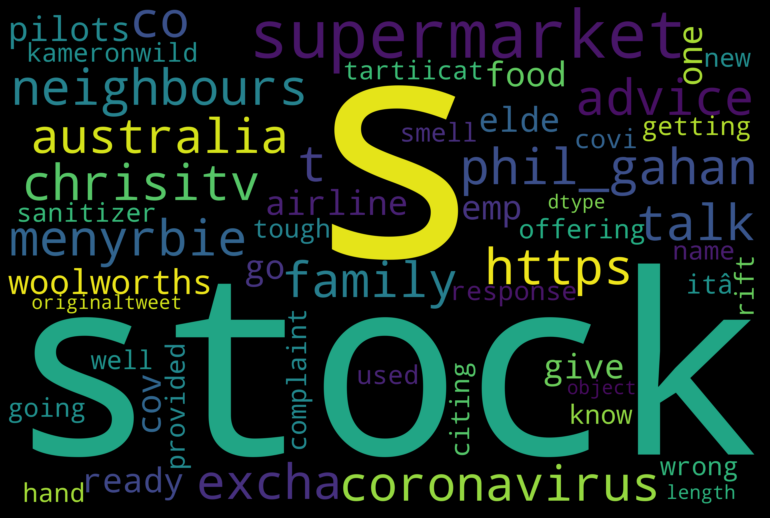

In [ ]:
# passing original tweet as text
wordcloud = word_cloud_poster(text = tweet_df['OriginalTweet'],
                              background_color= 'black', width=3000 , height= 2000)

# blank figure
fig = plt.figure(
    figsize = (14,7),
    facecolor = 'k',
    edgecolor = 'k')

# showing images of wordcloud object
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

* The stock market has collapsed due to the pandemic, so people are talking about it.
* Having trouble buying from the supermarket

# Machine Learning portion
**Splitting Training and Testing Data**

In [ ]:
# create dependent and independet features
X = tweet_df['Text']
y = tweet_df['Sentiment']

# Separate training and test data, Since the dataset is very large the test_size is 20%,
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state= 42, stratify= y)

In [ ]:
100 * y_test.value_counts() / len(y_test)

Positive              27.764277
Negative              24.106926
Neutral               18.712029
Extremely Positive    16.099635
Extremely Negative    13.317132
Name: Sentiment, dtype: float64

In [ ]:
100 * y.value_counts() / len(y)

Positive              27.759685
Negative              24.101978
Neutral               18.718709
Extremely Positive    16.098770
Extremely Negative    13.320857
Name: Sentiment, dtype: float64

**We can see that, due to stratification on y the training and test data are divided in the correct ratio.**

---

**Bag of Words**

Each vector will have as many dimensions as there are unique words in the SMS corpus.  We will first use SciKit Learn's **CountVectorizer**. This model will convert a collection of text documents to a matrix of token counts.

We can imagine this as a 2-Dimensional matrix. Where the 1-dimension is the entire vocabulary (1 row per word) and the other dimension are the actual documents, in this case a column per text message. 

For example:

<table border = “1“>
<tr>
<th></th> <th>Word 1 Count</th> <th>Word 2 Count</th> <th>...</th> <th>Word M
</tr>
<tr>
<td><b>Message 1</b></td><td>0</td><td>1</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>Message 2</b></td><td>0</td><td>0</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>...</b></td> <td>1</td><td>2</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>Message N</b></td> <td>0</td><td>1</td><td>...</td><td>1</td>
</tr>
</table>


Since there are so many messages, we can expect a lot of zero counts for the presence of that word in that document. Because of this, SciKit Learn will output a Sparse Matrix.


In [ ]:
# CountVectorizer with max_df is 90 percent and min_df is 10 
cv_model = CountVectorizer(max_df = 0.9, min_df = 10)

def cv_transformer(train_X, test_X, cv_mod= cv_model):
  '''
  return bag of words for train and test data.
  '''

  # fitting on training data only , fit on test data will lead to data leakage
  cv_mod.fit(train_X)

  # transform on both train and test data 
  train_X_cv = cv_mod.transform(train_X)
  test_X_cv = cv_mod.transform(test_X)

  return train_X_cv, test_X_cv


# Note INside function I used train_X (as local variable) , out side  X_train

**TF:** Term Frequency, which measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (aka. the total number of terms in the document) as a way of normalization:

$$tf(t,d) = \frac{Number\; of\; times\; term\; t\; appears\; in\; a\; document\;d}  {Total\; number\; of\; terms\; in\; the\; document \;d}$$


Mathematically

$$tf(t,d) = \frac{f_{t,d}}  {\sum_{t' \in d} f_{t',d}}$$

where $\;f_{t,d}\;$  is the raw count of a term in a document, i.e., the number of times that term t occurs in document d. 

<br/>

**IDF:** Inverse Document Frequency, which measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following:

<br/>
$$idf(t) = \log_e \left( \frac {Total\; number\; of\; documents} {Number\; of\; documents\; with\; term\; t\; in\; it} \right) $$

Mathematically

$$idf(t,d,D) = \log_e \left( \frac {N} {| \{ d \in D : t \in d  \} | } \right) $$

<br/>

Then tf–idf is calculated as

$$tf \textrm{-} idf(t,d,D) = tf(t,d) \cdot idf(t,d,D)$$

In [ ]:
# TfidfVectorizer with max_df is 90 percent and min_df is 10 
tfidf_model = TfidfVectorizer(max_df = 0.9, min_df = 10)

def tfidf_transformer(train_X, test_X, tfidf_model= tfidf_model):
  '''
  return TfidfVectorized train and test data.
  '''

  # fitting on training data only , fit on test data will lead to data leakage
  tfidf_model.fit(train_X)

  # transform on both train and test data 
  train_X_tfidf = tfidf_model.transform(train_X)
  test_X_tfidf = tfidf_model.transform(test_X)

  return train_X_tfidf, test_X_tfidf

**Define our machine learning models**

In [ ]:
# Fitting different models
model_dict = {
    'Logistic Regression': LogisticRegression(random_state= 101, max_iter= 500),
    'Linear SVC': LinearSVC(random_state= 101),
    'Multinomial NB': MultinomialNB(),
    'SGD Classifier': SGDClassifier(random_state= 101),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier()
}



def model_performance(train_X, test_X, train_y, test_y, models= model_dict):
  
  '''return dictionary that have accuracy of each model.'''

  # dictionary that we want to return
  models_data = {
      'Name': [],                   # Name of that model
      'time_taken_sec': [],         # time taken in training, predicting and calulation of accuracy
      'train_accuracy': [],         # accuracy of training set
      'test_accuracy': [],          # accuracy of testing set
      'trained_model': []           # trained (fitted) model on training data 
  }

  # models argument in this function is dictionary of ML models with their names 
  for model_name, model_type in models.items():

    print(f"We are at {model_name}")

    models_data["Name"].append(model_name)

    # statring time
    tic = time.time() 
  
    # fit on train data
    model_type.fit(train_X, train_y)
    
    models_data['trained_model'].append(model_type)

    # Training set, first perdict then calculate accuracy
    train_y_pred = model_type.predict(train_X)
    train_acc = accuracy_score(train_y, train_y_pred)

    models_data["train_accuracy"].append(train_acc)

    # Test set
    test_y_pred = model_type.predict(test_X)
    test_acc = accuracy_score(test_y, test_y_pred)

    models_data["test_accuracy"].append(test_acc)

    #end time
    tac = time.time()
    models_data["time_taken_sec"].append((tac - tic))

    # loop ended 

  return models_data

In [ ]:
# before passing data in ML models we first 
# transforming our training and test data to couvt vectorizer
X_train_cv, X_test_cv = cv_transformer(X_train, X_test)

# transforming our train and test data to tfidf vectorizer
X_train_tfidf, X_test_tfidf = tfidf_transformer(X_train, X_test)

In [ ]:
# pass the CV data into the models
cv_models_data = model_performance(X_train_cv, X_test_cv, y_train, y_test)   # passing in that function

We are at Logistic Regression
We are at Linear SVC
We are at Multinomial NB
We are at SGD Classifier
We are at Decision Tree


In [ ]:
# creating a dataframe from that dictionary and sort on the basis of test accuracy
cv_models_info = pd.DataFrame(cv_models_data).sort_values(by= 'test_accuracy', ascending= False)
cv_models_info

,Name,time_taken_sec,train_accuracy,test_accuracy,trained_model
0,Logistic Regression,15.788910,0.810062,0.609842,"LogisticRegression(max_iter=500, random_state=..."
3,SGD Classifier,1.784152,0.744258,0.573876,SGDClassifier(random_state=101)
1,Linear SVC,24.831917,0.781717,0.552491,LinearSVC(random_state=101)
4,Decision Tree,15.644328,0.999423,0.522236,DecisionTreeClassifier()
2,Multinomial NB,0.325510,0.610433,0.488578,MultinomialNB()


* CountVectorizer has better performance than TfIdfVectorizer.
* And the performance of logistic regression in that is the best, with 0.61 accuracy on test data.

**lets visualize and see other performance metrics**

In [ ]:
sns.set_style('white')

def report(model, train_X, test_X, test_y):
    preds = model.predict(test_X)
    print(classification_report(test_y, preds))
    
    plot_confusion_matrix(model, test_X, test_y)
    plt.xticks(rotation= 90)

Logistic Regression
                    precision    recall  f1-score   support

Extremely Negative       0.67      0.61      0.64      1096
Extremely Positive       0.72      0.64      0.68      1325
          Negative       0.53      0.52      0.53      1984
           Neutral       0.63      0.71      0.67      1540
          Positive       0.58      0.60      0.59      2285

          accuracy                           0.61      8230
         macro avg       0.63      0.62      0.62      8230
      weighted avg       0.61      0.61      0.61      8230



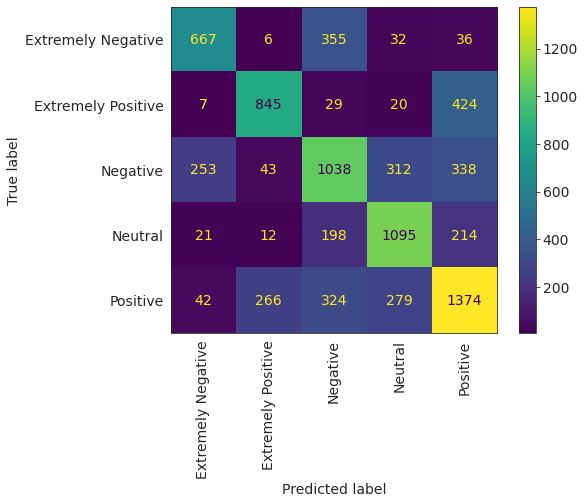

In [ ]:
print('Logistic Regression')

# select the model by index location
model = cv_models_info.loc[0]['trained_model'] 
report(model, X_train_cv, X_test_cv, y_test)

* Model have relatively high precision for Extremely Positive sentiment, and relativly high sensitivity  for neutral sentiment.

[**Plot ROC curves for the multiclass problem**](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html)

In [ ]:
def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(5,5)):
    y_score = clf.decision_function(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # colors 
    cols= ['#FF0000', '#008000', '#0000FF', '#5D3FD3', '#DAA520']

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values

    # lables in sorted order
    lables = pd.get_dummies(y_test, drop_first=False).columns
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label=f"ROC curve {round(roc_auc[i], 2)} for label " + lables[i], c = cols[i])
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

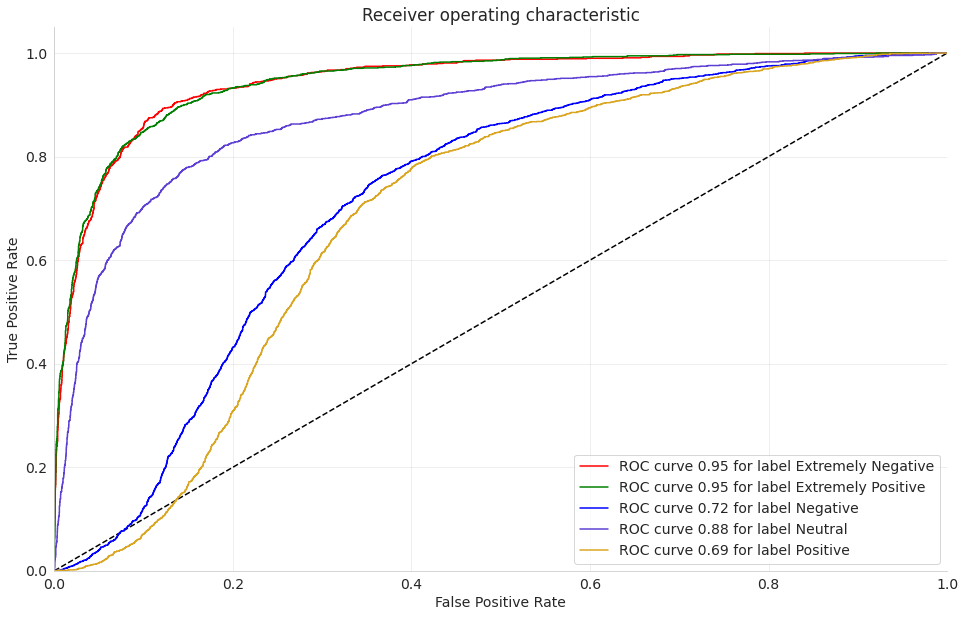

In [ ]:
# passing the logestic model in plot_multiclass_roc
sns.set_style('whitegrid')
model = cv_models_info.loc[0]['trained_model'] 
plot_multiclass_roc(model ,X_test_cv, y_test, n_classes= 5, figsize=(16, 10))

<p><img alt="Insight logo" src="https://drive.google.com/uc?export=view&id=15uX4fnuDMuki2xAnjK8wv-ifJhAkBtJ2" align="left" hspace="10px" vspace="0px"></p>

>**Insights:**

* Extreme sentiments tend to have a better AUC-ROC score, which means they can be easily differentiated from the rest.

----
* **We can see that since the target variable has five classes and the accuracy is not good we will convert it to a binary class.**

* **We will divide the sentiment into two parts, negative and non negative sentiments, negative means overall negative sentiment.** 

* **It was the time of the corona pandemic so we will see how many people are full of negativity and panic.**


In [ ]:
# create new column that return True if overall sentiment is negative
tweet_df['Is neg Sentiment'] = tweet_df['Sentiment'].apply(lambda x : True if x in ['Extremely Negative', 'Negative'] else False) 

In [ ]:
# lets check , overall negative sentiment should match
tweet_df['Is neg Sentiment'].sum()

15398

In [ ]:
# sentiment_count , we have created earlier
sentiment_count['Negative'] + sentiment_count['Extremely Negative']

15398

# Let's visualize

----

Negative Sentiment Tweet Rate per month

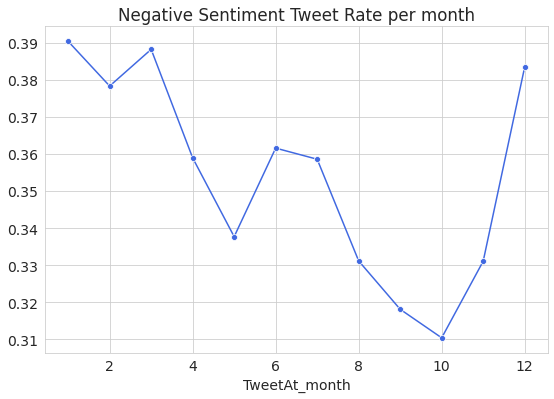

In [113]:
# Negative sentiment per month 
negtweet_per_month = tweet_df.groupby('TweetAt_month')['Is neg Sentiment'].sum()

# Positive sentiment per month
postweet_per_month = tweet_df.groupby('TweetAt_month')['Is neg Sentiment'].count() - negtweet_per_month

# negative sentiment rate per month
negtweet_sent_rate =  negtweet_per_month / (postweet_per_month + negtweet_per_month)

# line plot 
plt.figure(figsize= (9, 6))
sns.lineplot(x= negtweet_sent_rate.index, y= negtweet_sent_rate.values, marker= 'o')
plt.title("Negative Sentiment Tweet Rate per month");

* Over time, the trend of tweets with negative sentiment is decreasing except in the last two months.
____
**Top 18 words in tweets for negative and non-negative sentiments and their posters.**

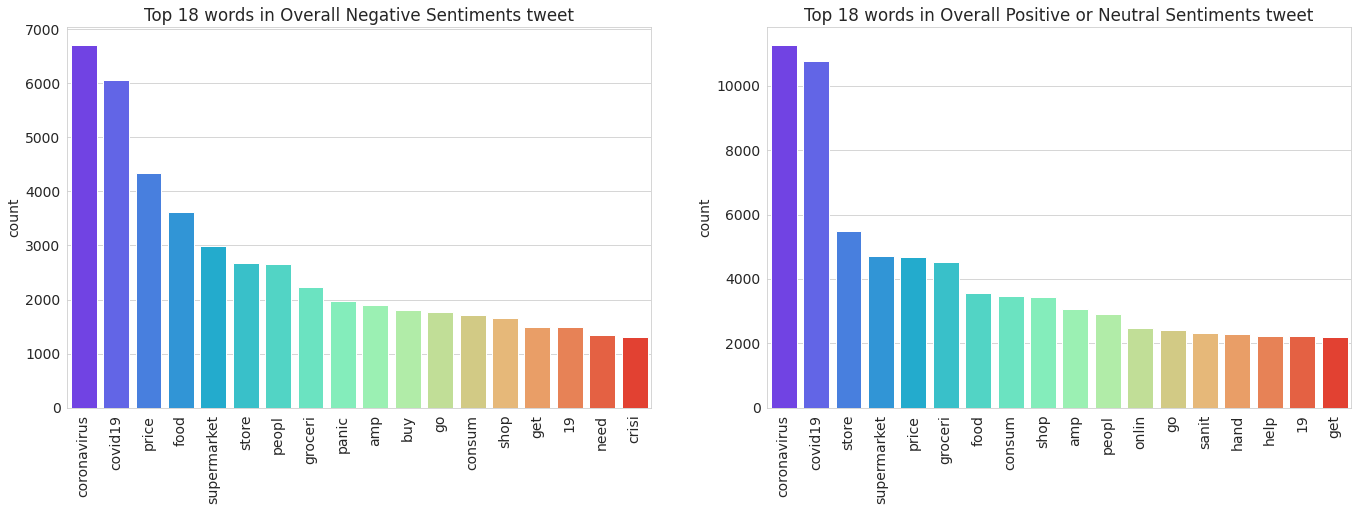

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize= (23,7))

# series of boolean value 
condition_bool = (tweet_df['Is neg Sentiment'] == True)

# series of processed tweet with overall negative sentiment
overall_negative = tweet_df['Text'][condition_bool]

# series of tweet with overall non negative sentiment, means neutral or overall positive sentiment
overall_non_negative = tweet_df['Text'][~condition_bool]

# plot is False means, it return list of tuple values
# top 18 words and its occurrence in overall_negative series
top_words_neg, top_values_neg = top_n_words(text_data= overall_negative, n_words= 18)

# its barplot  
sns.barplot(x= top_words_neg, y = top_values_neg, palette= 'rainbow', ax= ax[0])

# top 18 words and its occurrence in overall_non_negative
top_words_non_neg, top_values_non_neg = top_n_words(text_data= overall_non_negative, n_words= 18)

# its bar plot
sns.barplot(x= top_words_non_neg, y = top_values_non_neg, palette= 'rainbow', ax= ax[1])


# set titles, y labels and rotate x labels
ax[0].set_ylabel('count')
ax[1].set_ylabel('count')

ax[0].set_title('Top 18 words in Overall Negative Sentiments tweet')
ax[1].set_title('Top 18 words in Overall Positive or Neutral Sentiments tweet')

ax[0].set_xticklabels(top_words_neg, rotation=90)
ax[1].set_xticklabels(top_words_non_neg, rotation=90);

In [ ]:
# wordcloud object for negatively sentiment tweet
wordcloud_neg = word_cloud_poster(text = overall_negative,
                                  background_color= 'black', width=3000 , height= 2000)

# wordcloud object for non negatively sentiment tweet
wordcloud_non_neg = word_cloud_poster(text = overall_non_negative,
                                  background_color= 'black', width=3000 , height= 2000)

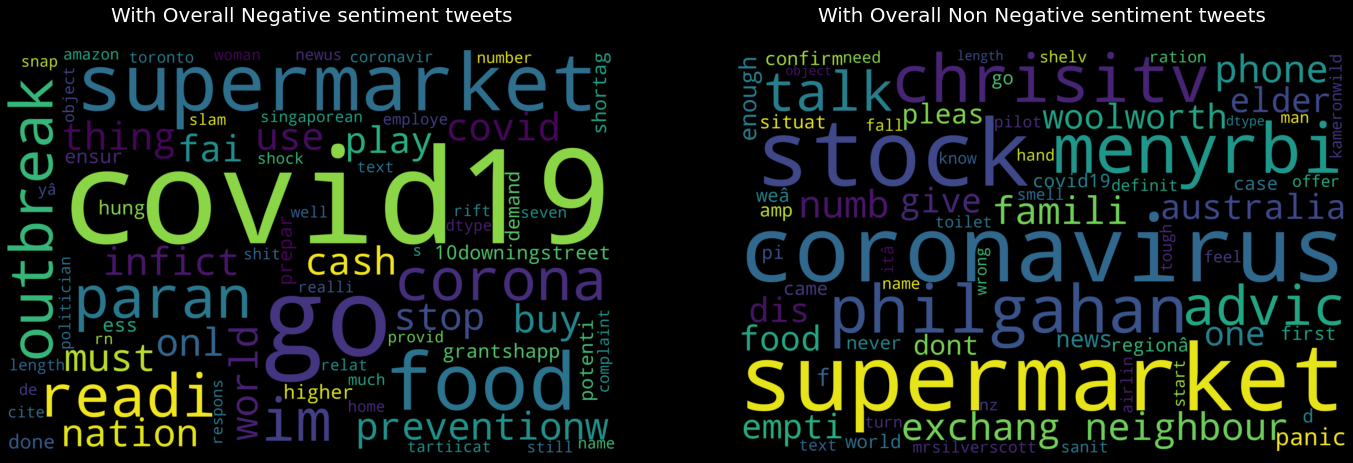

In [ ]:
# create blank object
fig, ax = plt.subplots(nrows= 1, ncols= 2, 
                       figsize= (24,10), facecolor = 'k', edgecolor = 'k')

# showing object, remove grid and set titles
ax[0].imshow(wordcloud_neg, interpolation = 'bilinear')
ax[0].axis('off')
ax[0].set_title('With Overall Negative sentiment tweets\n', size=20, color='white')

ax[1].imshow(wordcloud_non_neg, interpolation = 'bilinear')
ax[1].axis('off')
ax[1].set_title('With Overall Non Negative sentiment tweets\n', size=20, color='white');

In [ ]:
# let's check all columns
tweet_df.columns

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment', 'TweetAt_month', 'Quarter', 'Length of tweet', 'Text',
       'Length of Text', 'Hashtags', 'Is neg Sentiment'],
      dtype='object')

In [ ]:
# create dependent and independet features
X_new = tweet_df['Text']
y_new = tweet_df['Is neg Sentiment']

# Separate training and test data, Since the dataset
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new,test_size=0.2,random_state= 42, stratify= y_new)

In [ ]:
# lets check the class balance, in test and overall set
100 * y_test_new.value_counts() / len(y_test_new)

False    62.575942
True     37.424058
Name: Is neg Sentiment, dtype: float64

In [ ]:
100 * y_new.value_counts() / len(y_new)

False    62.577164
True     37.422836
Name: Is neg Sentiment, dtype: float64

In [ ]:
# transforming our training and test data to couvt vectorizer
X_train_new_cv, X_test_new_cv = cv_transformer(X_train_new, X_test_new)

# transforming our train and test data to tfidf vectorizer
X_train_new_tfidf, X_test_new_tfidf = tfidf_transformer(X_train_new, X_test_new)

In [ ]:
# train our data in ml algorithms
cv_models_data_new = model_performance(X_train_new_cv, X_test_new_cv, y_train_new, y_test_new)  

We are at Logistic Regression
We are at Linear SVC
We are at Multinomial NB
We are at SGD Classifier
We are at Decision Tree


In [ ]:
cv_models_info_new = pd.DataFrame(cv_models_data_new).sort_values(by= 'test_accuracy', ascending= False)
cv_models_info_new

,Name,time_taken_sec,train_accuracy,test_accuracy,trained_model
3,SGD Classifier,0.230715,0.905304,0.861118,SGDClassifier(random_state=101)
0,Logistic Regression,1.351298,0.904818,0.857959,"LogisticRegression(max_iter=500, random_state=..."
1,Linear SVC,4.404148,0.912170,0.848117,LinearSVC(random_state=101)
2,Multinomial NB,0.021612,0.813677,0.788821,MultinomialNB()
4,Decision Tree,10.581811,0.999666,0.769623,DecisionTreeClassifier()


LogisticRegression with CountVectorizer

              precision    recall  f1-score   support

       False       0.87      0.91      0.89      5150
        True       0.83      0.78      0.80      3080

    accuracy                           0.86      8230
   macro avg       0.85      0.84      0.85      8230
weighted avg       0.86      0.86      0.86      8230



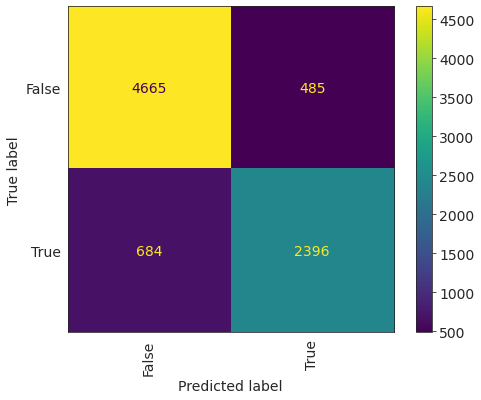

In [ ]:
print('LogisticRegression with CountVectorizer\n')

sns.set_style('white')

# select the model by index location
model = cv_models_info_new.loc[0]['trained_model'] 
report(model, X_train_new_cv, X_test_new_cv, y_test_new)

StochasticGradientDescent with CountVectorizer

              precision    recall  f1-score   support

       False       0.88      0.90      0.89      5150
        True       0.82      0.80      0.81      3080

    accuracy                           0.86      8230
   macro avg       0.85      0.85      0.85      8230
weighted avg       0.86      0.86      0.86      8230



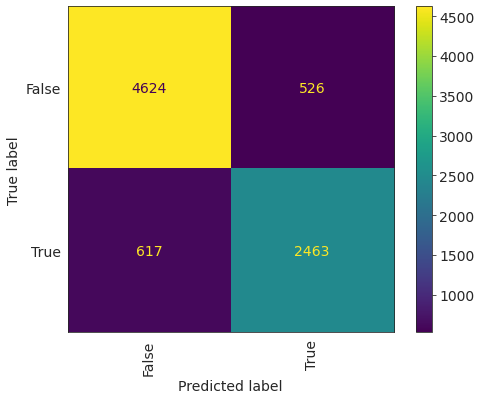

In [ ]:
print('StochasticGradientDescent with CountVectorizer\n')

# select the model by index location
model = cv_models_info_new.loc[3]['trained_model'] 
report(model, X_train_new_cv, X_test_new_cv, y_test_new)

In [ ]:
# train our data in ml algorithms
tfidf_models_data_new = model_performance(X_train_new_tfidf, X_test_new_tfidf, y_train_new, y_test_new)  

We are at Logistic Regression
We are at Linear SVC
We are at Multinomial NB
We are at SGD Classifier
We are at Decision Tree


In [ ]:
tfidf_models_info_new  = pd.DataFrame(tfidf_models_data_new).sort_values(by= 'test_accuracy', ascending= False)
tfidf_models_info_new

,Name,time_taken_sec,train_accuracy,test_accuracy,trained_model
1,Linear SVC,0.357370,0.905213,0.855650,LinearSVC(random_state=101)
0,Logistic Regression,0.950244,0.873375,0.844836,"LogisticRegression(max_iter=500, random_state=..."
3,SGD Classifier,0.104440,0.857364,0.834508,SGDClassifier(random_state=101)
2,Multinomial NB,0.020217,0.807905,0.781409,MultinomialNB()
4,Decision Tree,19.457003,0.999635,0.755286,DecisionTreeClassifier()


LinearSVC with TfIdfVectorizer

              precision    recall  f1-score   support

       False       0.87      0.90      0.89      5150
        True       0.83      0.77      0.80      3080

    accuracy                           0.86      8230
   macro avg       0.85      0.84      0.84      8230
weighted avg       0.85      0.86      0.85      8230



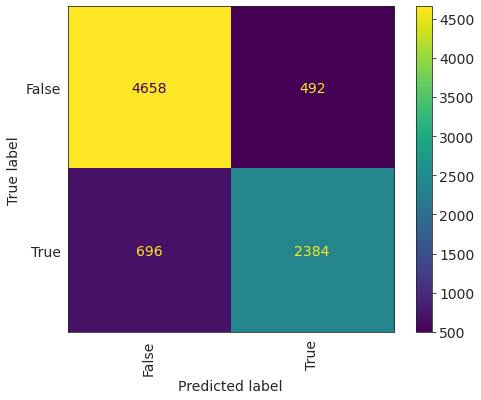

In [ ]:
print('LinearSVC with TfIdfVectorizer\n')

# select the model by index location
model = tfidf_models_info_new.loc[1]['trained_model'] 
report(model, X_train_new_tfidf, X_test_new_tfidf, y_test_new)

<p><img alt="Insight logo" src="https://drive.google.com/uc?export=view&id=15uX4fnuDMuki2xAnjK8wv-ifJhAkBtJ2" align="left" hspace="10px" vspace="0px"></p>

>**Insights:**

* Cunt Vectorizer model has better performance in Logistic Regression and Stochastic Gradient Descent Classifier.

* TfIdf Vectorizer model has better performance in LinearSVC.

**Plotting the test accuracy**

In [ ]:
# we have to create some label that can differentiate cv and tfidf of same model

def tag_creater(model_name, tag):
  """
  function that combine ML model to bag of words model , tag is either cv or tfidf
  """
  return model_name + ' ' + tag

In [ ]:
# creating new column
tfidf_models_info_new['Tag'] =  tfidf_models_info_new.apply(lambda x: tag_creater(x['Name'], 'tfidf'), axis= 1)
cv_models_info_new['Tag'] = cv_models_info_new.apply(lambda x: tag_creater(x['Name'], 'cv'), axis= 1)

# concatenate above two dataframes 
concat_model_info = pd.concat([cv_models_info_new, tfidf_models_info_new], axis= 0).sort_values(by= 'test_accuracy', ascending= False)
concat_model_info

,Name,time_taken_sec,train_accuracy,test_accuracy,trained_model,Tag
3,SGD Classifier,0.230715,0.905304,0.861118,SGDClassifier(random_state=101),SGD Classifier cv
0,Logistic Regression,1.351298,0.904818,0.857959,"LogisticRegression(max_iter=500, random_state=...",Logistic Regression cv
1,Linear SVC,0.357370,0.905213,0.855650,LinearSVC(random_state=101),Linear SVC tfidf
1,Linear SVC,4.404148,0.912170,0.848117,LinearSVC(random_state=101),Linear SVC cv
0,Logistic Regression,0.950244,0.873375,0.844836,"LogisticRegression(max_iter=500, random_state=...",Logistic Regression tfidf
3,SGD Classifier,0.104440,0.857364,0.834508,SGDClassifier(random_state=101),SGD Classifier tfidf
2,Multinomial NB,0.021612,0.813677,0.788821,MultinomialNB(),Multinomial NB cv
2,Multinomial NB,0.020217,0.807905,0.781409,MultinomialNB(),Multinomial NB tfidf
4,Decision Tree,10.581811,0.999666,0.769623,DecisionTreeClassifier(),Decision Tree cv
4,Decision Tree,19.457003,0.999635,0.755286,DecisionTreeClassifier(),Decision Tree tfidf


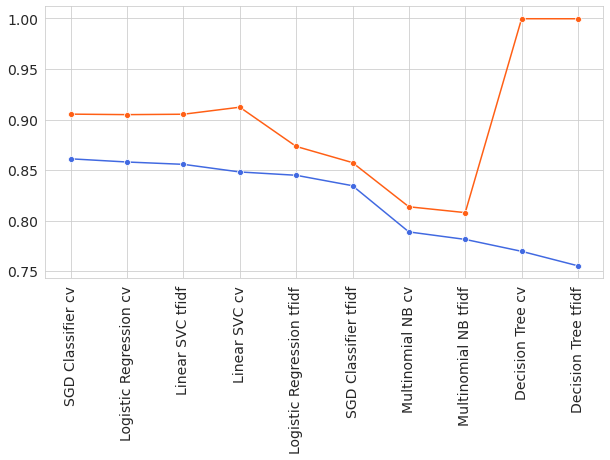

In [ ]:
# lets plot testing accuracy of all models
sns.set_style('whitegrid')
plt.figure(figsize= (10,5))

# lineplot for test accuracy
sns.lineplot(x= concat_model_info['Tag'].values ,y= concat_model_info['test_accuracy'].values, marker= 'o')

# line plot for train accuracy
sns.lineplot(x= concat_model_info['Tag'].values ,y= concat_model_info['train_accuracy'].values, marker= 'o')

plt.xticks(rotation= 90);

<p><img alt="Insight logo" src="https://drive.google.com/uc?export=view&id=15uX4fnuDMuki2xAnjK8wv-ifJhAkBtJ2" align="left" hspace="10px" vspace="0px"></p>

>**Insights:**

The Stochastic Gradient Descent Classifier with Countvectorizer has the best performance among all the models.

<br/>

# Hyperparameter Tuning for better accuracy with grid search by making pipeline

Hyperparameter optimization or tuning is the problem of choosing a set of optimal hyperparameters for a learning algorithm. A hyperparameter is a parameter whose value is used to control the learning process. By contrast, the values of other parameters (typically node weights) are learned.

For tunning hyperparamete I am choosing choose  
  1. SGD classifier with count vectorizer
  2. Linear SVC with tf-idf vectorizer

In [ ]:
def hyperparameter_tuning(clf_model, params_dict, vectorize_model, k_fold= 5):
  """
  Take model and its hyperparameters as input and return best fitted model
  """

  # making pipeline object
  pipe = Pipeline([   
      ('vectorize_model',vectorize_model),  
      ('clf_model', clf_model)
  ])


  # add clf_model__ in front of each key of params_dict 
  param_grid = dict()
  
  for key, val in params_dict.items():
    
    key = 'clf_model__' + key

    param_grid[key] = val

  

  # stratified cross validation
  stratified_kfold = StratifiedKFold(n_splits= k_fold,
                                       shuffle=True,
                                       random_state=11) 

  #  Grid Search object
  grid_search = GridSearchCV(
          estimator= pipe,
          param_grid= param_grid,
          scoring= 'accuracy',
          cv= stratified_kfold,
          n_jobs= -1,
          verbose= 1
  )

  # Strat
  tic = time.time()

  # fit on grid search
  grid_search.fit(X_train_new, y_train_new)

  # End
  tac = time.time()

  print(f"Time taken in hyper-parameter tuning : {round(tac-tic, 2)} sec")   
  print(120 * '_', end= '\n' * 2)

  # we dont want clf_model__ 
  print("Best Parameters are")
  for key, val in  grid_search.best_params_.items():
    
    key = key.split('__')[-1]  
    print(f"{key} : {val}")
  
  print(120 * '_', end= '\n' * 2)
  # calculate accuracy with test data
  accuracy = grid_search.score(X_test_new, y_test_new)
  
  print(f"Best accuracy is {accuracy}")

  return grid_search

In [ ]:
# MODEL
svc_clf = LinearSVC(random_state= 101)

# dictionary of hyperparameters
svc_clf_params = dict(
  C = np.logspace(-1, 1, 10),        #  10 logrethemic spaced values between 0.1 to 10       
  penalty = ['l1', 'l2'],
  loss = ['hing', 'squared_hinge']
)

# SGD classifier with best parameters
best_sgd_clf = hyperparameter_tuning(svc_clf, svc_clf_params, tfidf_model)    # It will take 2 minutes 

* Accuracy is not much improved

In [ ]:
# MODEL
sgd_clf = SGDClassifier(random_state= 0)

# dictionary of hyperparameters
sgd_clf_params = dict(
  penalty = ["l1", "l2", 'elasticlet'],
  max_iter=[50, 100, 200, 500],
  l1_ratio = [0.1, 0.5, 0.95, 0.99],
  loss = ['hinge', 'log_loss']
)

# SGD classifier with best parameters
best_sgd_clf = hyperparameter_tuning(sgd_clf, sgd_clf_params, cv_model)   

Fitting 5 folds for each of 480 candidates, totalling 2400 fits
Time taken in hyper-parameter tuning : 2120.29 sec
________________________________________________________________________________________________________________________

Best Parameters are
l1_ratio : 0.1
loss : hinge
max_iter : 100
penalty : l1
________________________________________________________________________________________________________________________

Best accuracy is 0.8753341433778857


<p><img alt="Insight logo" src="https://drive.google.com/uc?export=view&id=15uX4fnuDMuki2xAnjK8wv-ifJhAkBtJ2" align="left" hspace="10px" vspace="0px"></p>

>Accuracy increased from 86.11 to 87.53 percent and performance is best with
* L1 (lasso) regularization.
* Maximum iteration is 100.
* l1_ratio have significance only for elastic net regularization, for Ridge and Lasso it is useless parameter better to ignore it.

In [ ]:
# best estimator
best_sgd_clf_model = best_sgd_clf.best_estimator_
best_sgd_clf_model

Pipeline(steps=[('vectorize_model', CountVectorizer(max_df=0.9, min_df=10)),
                ('clf_model',
                 SGDClassifier(l1_ratio=0.1, max_iter=100, penalty='l1',
                               random_state=0))])

Stochastic Gradient Descent Classifiers, Grid model  

              precision    recall  f1-score   support

       False       0.89      0.92      0.90      5150
        True       0.85      0.81      0.83      3080

    accuracy                           0.88      8230
   macro avg       0.87      0.86      0.87      8230
weighted avg       0.87      0.88      0.87      8230



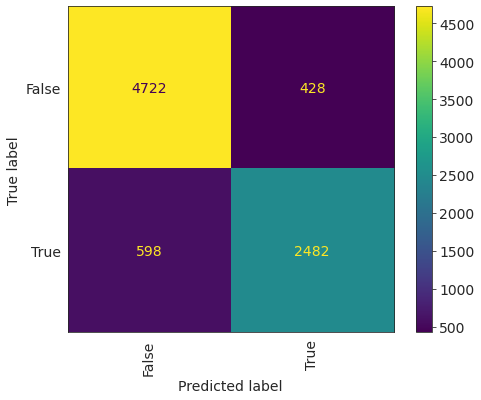

In [ ]:
sns.set_style('white')
print('Stochastic Gradient Descent Classifiers, Grid model  \n')

report(best_sgd_clf_model, X_train_new, X_test_new, y_test_new)

# Evaluating Curves and AUC

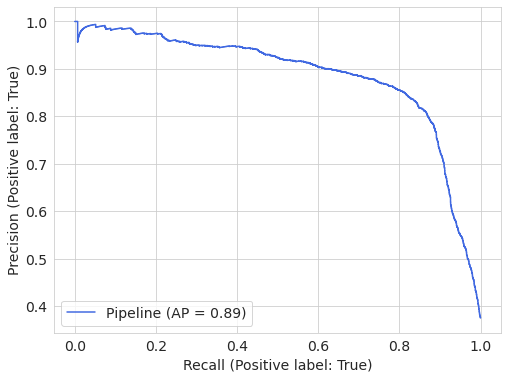

In [ ]:
# Precision vs recall curve
sns.set_style('whitegrid')
plot_precision_recall_curve(best_sgd_clf_model, X_test_new, y_test_new);

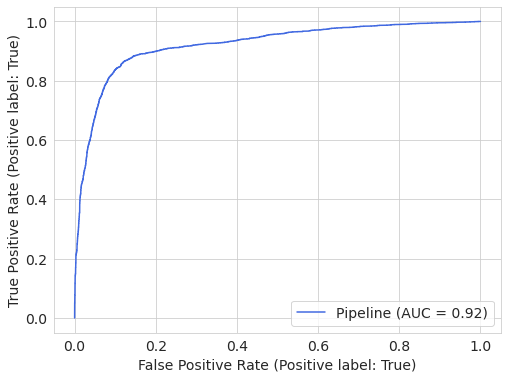

In [ ]:
# ROC - AUC
plot_roc_curve(best_sgd_clf_model, X_test_new, y_test_new);

<p><img alt="Insight logo" src="https://drive.google.com/uc?export=view&id=15uX4fnuDMuki2xAnjK8wv-ifJhAkBtJ2" align="left" hspace="10px" vspace="0px"></p>

> **After hyperparameter tuning of SGDClassifier**
* Area under Receiver Operating Characteristic curve is 0.92. 
* Area under precision-recall curve is 0.89.
* Accuracy is 87.53 percent.

# LIME

LIME helps us provide an explanation not only to end users but also to ourselves about how a specific NLP model works.

In [ ]:
# Grab the SGDClassifier with best parameter
sgd_clf = SGDClassifier(penalty='l1', random_state= 101)

#  SGDClassifier with 'hing' loss with don't have predict probability like Logistic regression, so I am using 
#  CalibratedClassifierCV which is a sort of meta-estimator; to use it, you simply pass your instance of a base estimator to its constructor 
# due to  CalibratedClassifierCV we have to train the model otherwise we can use best_sgd_clf_model

# passing the SGDClassifier model as base estimator
calibrator = CalibratedClassifierCV(sgd_clf)

# making pipeline for prediction
pipe_pred = make_pipeline(cv_model, calibrator)

# If we want direct sentiment prediction then we have to pass data in  trained grid_search model , but
# here for predicting probability we need to tarin the model again due to  CalibratedClassifierCV

# fiting data to pipeline
pipe_pred.fit(X_train_new, y_train_new)


Pipeline(steps=[('countvectorizer', CountVectorizer(max_df=0.9, min_df=10)),
                ('calibratedclassifiercv',
                 CalibratedClassifierCV(base_estimator=SGDClassifier(penalty='l1',
                                                                     random_state=101)))])

In [ ]:
def show_explainer(new_tweet, pipeline= pipe_pred):
  
  '''function that show LIME Explainer'''

  # Pass the title in Explainer
  explainer = LimeTextExplainer(class_names=["Non Negative", "Negative Sentiment"])

  # Create the LIME Explainer
  exp = explainer.explain_instance(new_tweet, 
                                 pipe_pred.predict_proba, num_features=5)
  
  # Show the LIME Explainer
  exp.show_in_notebook(text=True)

In [ ]:
# Lets grab a tweet from original Tweet
new_text = tweet_df['OriginalTweet'].iloc[11]
print(new_text)





We thank you for your patience during this time.


In [ ]:
# show LIME Explainer
show_explainer(new_text)

* here is a 27% chance that this tweet is accompanied by a negative sentiment.
* **"thank"** and **"share"** word are responsible for overall positive or neutral sentiment.
* **"demand"**, **"all"** and **"be"** are responsible for overall negative sentiment. 
-----

## Model Persistence (Saving and Loading a Model)

In [ ]:
import joblib

joblib.dump(pipe_pred, 'corona_tweet_sentiment.joblib') 

# The object can be loaded back using joblib.load
loaded_model = joblib.load('corona_tweet_sentiment.joblib')

In [ ]:
# let's predict your tweets, we can choose any tweet from out data set or any new tweet
# True means tweet with negative , False means non negative sentiment
loaded_model.predict([new_text])

In [ ]:
# this time I will pass loded model
show_explainer(new_text, loaded_model)

**Let's take another example from negative sentiment**

In [ ]:
another_tweet = tweet_df['OriginalTweet'].iloc[50]

# let's predict sentimet of tweets
loaded_model.predict([another_tweet])

In [ ]:
# show LIME Explainer
show_explainer(another_tweet, loaded_model)

* Panic, fear, racism and other words are in tweet, so its sentiment is negative.

<a href="https://www.freeiconspng.com/img/6071" title="Image from freeiconspng.com"><img src="https://www.freeiconspng.com/uploads/summary-png-icon-1.png" width="70" alt="Free Files Summary" /></a>

# ***Summary*** 
---

>The following topics were covered in this notebook:
- Downloading a real-world dataset
- Looking for null and missing values
- Try to get some insights from data
- Data Cleaning, Preprocessing and Feature engineering, converting text formet to bag of words . 
- Preparing a dataset for training
- Training and interpretation with different models
- Overfitting, hyperparameter tuning & regularization
- Predict and calculate sum evaluation metrics for model
- Making predictions on single inputs and its probability on LIME
- Model Persistence saving and loading the model


<p><img alt="Insight logo" src="https://drive.google.com/uc?export=view&id=14dpaeXX-ajsM8quwe3dCCdQdrdvf29iI" align="left" hspace="20px" vspace="20px" width="45" height="60" ></p>



# **Overall Conclusion**
---
---
---
<br/>

> **Examining Null Values**
* Location Column have approx 20 percent missing values.
* No missing values were found in the OriginalTweets and Sentiment columns.

<br/>

> **Exploratory Data Analysis**
- Length of the tweets is negatively skewed.
- Length of neutral sentiment tweet is positively skewed.
- As the location suggests, most of the places are from English speaking countries or country where people understand English, such as UK, USA, India, Canada, Australia etc., and among these most of them are also from the US and UK.
- The first quarter has the highest percentage of overall negative sentiment tweets as compared to the other.
-  By analyzing hashtags
  -  Most of the them are about corona virus outbreak and pandemic, Social distancing, lockdown , staying at home etc..
  - Due to the lockdown, people are also facing problems due to the closure of supermarkets, shortage of food, and running out of toilet papers.

<br/>

> **Natural Language Processing and Machine Learning**
- Even after passing through different machine learning models, we noticed that there is not much improvement in accuracy, so I changed the Sentiment feature to Binary class and the accuracy improved from 61 to 86 percent. 
- Among all models SGD gave best performance so I tune its hyperparameters using grid search with five fold stratified cross validation, and accuracy has increased to 87.5 percent.
- Area under ROC curve is 0.92 , area under precision-recall curve is 0.89.

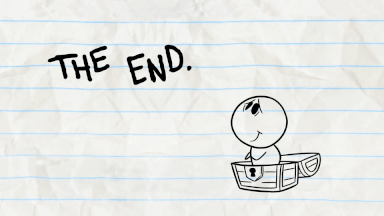